# Lesson 2: Deployment

For this mini-project we will train a new model, use it to clean our data, and deploy it to a huggingface space using gradio. Huggingface spaces allow for the easy creation of simple, interactive web pages and are perfect for deploying models and allowing users to interact with them.

In [ ]:
! pip install duckduckgo_search
! pip install fastai

For this project, let's build an image classifier that identifies Birds of Prey. Birds of Prey https://en.wikipedia.org/wiki/Bird_of_prey are 'hypercarnivorous bird species that actively hunt and feed on other vertebrates (mainly mammals, reptiles and other smaller birds). In addition to speed and strength, these predators have keen eyesight for detecting prey from a distance or during flight, strong feet with sharp talons for grasping or killing prey, and powerful, curved beaks for tearing off flesh.' 

We'll be focusing on the following classes: Eagles, Hawks, Falcons, Owls, and Vultures.

In [16]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from time import sleep

We'll use similar techniques to the previous lesson to download a dataset.

In [ ]:
classes = ['eagle', 'hawk', 'falcon', 'owl', 'vulture']
actions = ['flying', 'perched', 'diving']

path = Path('birds_of_prey')

def search_images(term, max_images=30):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

for c in classes:
    p = path/c
    dest = (p)
    dest.mkdir(parents=True, exist_ok=True)
    for action in actions:
        download_images(dest, urls=search_images(f'{c} {action}'), max_pics=50)
        sleep(5)
    download_images(dest, urls=search_images(f'{c}'), max_pics=50)
    sleep(5)
    resize_images(p, max_size=400, dest=p)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

Rather than using a simple Resize like last time, we'll use RandomResizedCrop, which randomly selects a cropped section of the image of the size we specify. We'll set min_scale at 0.6 to ensure that we still capture larger parts of the image.

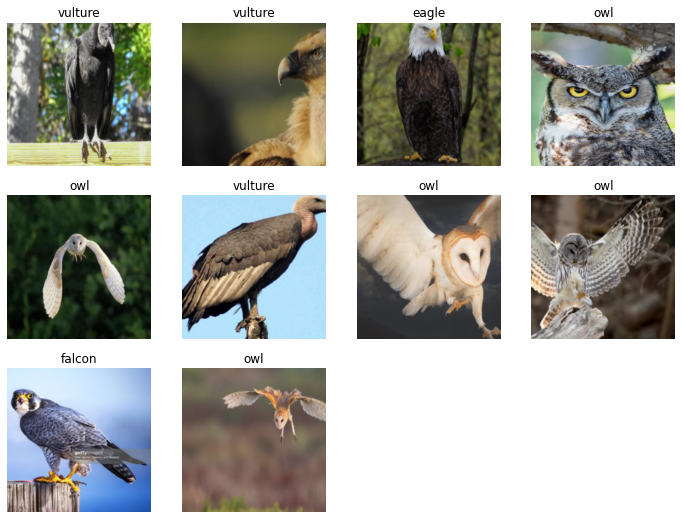

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=78),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(256, min_scale=0.6)
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

These images look excellent. I tried to use queries that would allow for our dataset to include birds in various motions, and it looks like I probably succeeded. Next, we can go ahead and train our model. We'll use some of the results to help clean out any bad images in our dataset and improve the model further.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.015093,0.515220,0.192982,01:39


epoch,train_loss,valid_loss,error_rate,time
0,0.773688,0.372348,0.122807,02:29
1,0.533148,0.334965,0.114035,02:31
2,0.426430,0.304195,0.087719,02:30
3,0.333697,0.300099,0.096491,02:29


With an erorr rate of around 9%, our model is good but not perfect. One method for seeing where and how our model is going wrong is a confusion matrix:

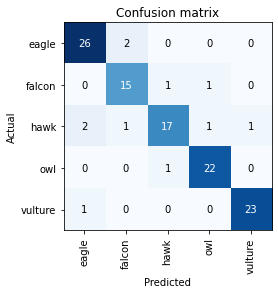

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

One thing to notice is that while our model is making mistakes, there is no pattern, and no outlying comparison that our model seem to especially struggle with. Let's view some of the images with the highest loss in our dataset:

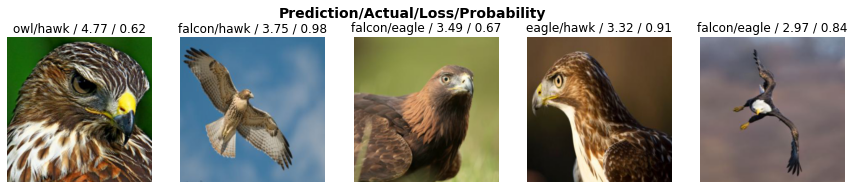

In [14]:
interp.plot_top_losses(5, nrows=1)

This is one method we could use to perhaps remove images that are mislabled or otherwise don't belong to the dataset (as our model would tend to struggle with these!). That being said, none of these images seem particularly problematic.

We can also try the fastai ImageClassifierCleaner mentioned in lecture, which provides a GUI for going through images in the dataset and allows for removing and relabeling.

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

After glancing over these I couldn't really find arguments for removing any single image in the dataset. If I had found some, I could relabel/remove appropriately and then re-train the model, in order to hopefully see better performance! Since we did not change the dataset, we can move on to model deployment.

In order to deploy the model, we need to export it to a pickle file! This file will save the state of the model and allow us to import it and use it elsewhere without training it again.

In [ ]:
learn.export()

The lecture notes suggest using the package viola to export code from our notebook in order to write our app. I would never do that in real life, so I'm just going to write the app the normal-person way, and paste a link to the resultant deployment below. The file is 'app.py' and it is written in the same directory as this notebook.